In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

In [781]:
def detect_outliers(x):

    m = np.mean(x)
    std = np.std(x)
    outlier_idx = np.where((m - 3 * std > x) | (m + 3 * std < x))[0]

    return outlier_idx

def table_entry(zero, ir, temp, param):

    """
    Mapping sensor measurements to concentration level of CO2 based on Beer-Lambert Law
    :param zero: zero calibration parameter
    :param ir: amount of IR light received by detector
    :param temp: measured environmental temperature
    :param s: span calibration parameter
    :param t0: full transmittance (scaled and shifted transmittance when the target concentration is zero)
    :param tz: temperature calibration parameter, describes the temperature dependency of zero
    :param tz2: temperature calibration parameter, describes the temperature dependency of zero
    :param ts: temperature calibration parameter, describes the temperature dependency of span
    :param ts2: temperature calibration parameter, describes the temperature dependency of span
    :return: table entry
    """

    '''
    The formula is owned by the company.
    '''

    return table_entry

def zero_cal(cc_mea, ir, temp, param):

    """
    Mapping measured concentration level of CO2 to transmittance to calculate zero coefficient
    :param cc_mea: measured concentration level of CO2
    :param cc: concentration level of CO2 offered in the mapping table
    :param te: table entry (transmittance) in the mapping table
    :return: calculated zero coefficient for each concentration level of CO2
    """

    global te, cc
    
    '''
    The formula is owned by the company.
    '''

    return zero

def viterbi_log(y, pi, A, B):

    """
    Viterbi Algorithm
    :param y: observations (N, )
    :param pi: state probability (S, )
    :param A: transition probability matrix (S, S)
    :param B: observation probability matrix (S, N)
    :return: predicted state sequence (N, )
    """

    S = A.shape[0]    # Number of states
    N = len(y)  # Length of observation sequence
    tiny = np.finfo(0.).tiny
    pi_log = np.log(pi + tiny)
    A_log = np.log(A + tiny)
    B_log = np.log(B + tiny)

    # Initialization
    ### Viterbi probability vector
    D_log = np.zeros((S, N))
    D_log[:, 0] = pi_log + B_log[:, y[0]]
    ### Viterbi backpointer matrix
    E = np.zeros((S, N - 1)).astype(np.int32)

    # Viterbi forward step
    for n in range(1, N):
        for i in range(S):
            temp_sum = A_log[:, i] + D_log[:, n - 1]
            D_log[i, n] = np.max(temp_sum) + B_log[i, y[n]]
            E[i, n - 1] = np.argmax(temp_sum)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D_log[:, -1])
    for n in range(N - 2, -1, -1):
        S_opt[n] = E[int(S_opt[n + 1]), n]

    return S_opt

def mapping(x_q, x_bins):

    x_itvl = x_bins[-1] - x_bins[-2]      # interval
    x_hat = np.zeros(len(x_q))
    for i in np.unique(x_q):
        if i == 0:
            x_hat[x_q == i] = x_bins[0] - x_itvl / 2
        elif i == len(x_bins):
            x_hat[x_q == i] = x_bins[-1] + x_itvl / 2
        else:
            x_hat[x_q == i] = (x_bins[i] + x_bins[i - 1]) / 2

    return x_hat

def plot_figs(y, xticks, fig='CO2'):

    n = len(y[0])
    plt.figure()
    for yy in y:
        plt.plot(np.arange(n), yy)
    if fig == 'CO2_mea':
        plt.xlabel('Date')
        plt.ylabel('Concentration level of CO2 (ppm)')
        plt.legend(labels=['measured'])
        plt.title('Concentration Level of CO2')
    if fig == 'CO2':
        plt.xlabel('Date')
        plt.ylabel('Concentration level of CO2 (ppm)')
        #plt.legend(labels=['reference', 'predicted', 'baseline'])
        plt.legend(labels=['reference', 'predicted', 'measured', 'baseline'])
        plt.title('Concentration Level of CO2')
    if fig == 'states':
        plt.xlabel('Date')
        plt.ylabel('Hidden state')
        plt.legend(labels=['calculated with reference', 'predicted'])
        plt.title('Hidden States')
    if fig == 'zeros':
        plt.xlabel('Date')
        plt.ylabel('Zero coefficient')
        plt.legend(labels=['calculated with reference', 'predicted', 'baseline'], loc='lower right')
        # plt.legend(labels=['calculated with reference', 'predicted', 'measured', 'baseline'], loc='lower right')
        plt.title('Zero Coefficients')
    plt.xticks(np.arange(0, n, step=int(n / 2 - 1)), xticks[:: int(n / 2 - 1)])
    plt.show()

In [ ]:
def load_data(path, label, start, length, step):

    """
    Obtain data for supervised HMM learning.
    :param label: label of sensor, e.g. label=01
    """

    global param, zeros, mea_zeros, data_date, data_temp, data_ir, data_CO2, ref_CO2, N

    # Obtain sensor parameters
    info = pd.read_csv('SensorsParams.csv', delimiter=';', index_col=0)   # LP8 sensors
    param = info.loc['S' + label, :]
    # Preprocess data
    # Format 1
    data = pd.read_csv(path + '/kth_logger_' + label + '.csv', header=None, delimiter=';')
    data = data.loc[:, [0, 1, 5, 6, 8, 10]]
    data = data.dropna()
    data = data.drop(data.index[detect_outliers(data[5])])
    data = data.drop(data.index[detect_outliers(data[6])])
    data = data.drop(data.index[detect_outliers(data[8])])
    data = data.drop(data.index[detect_outliers(data[10])])
    print('data collected: ', len(data))
    data = data[start: start + step * length: step]
    data_date = np.array(data[0] + ' ' + data[1])
    data_temp = np.array(data[6])
    data_ir = np.array(data[10]) / 256
    data_CO2 = np.array(data[8])
    ref_CO2 = np.array(data[5])
    '''
    # Format 2
    data = pd.read_csv(path + '/kth_logger_' + label + '.csv', header=None)
    data = data.loc[:, [0, 4, 5, 7, 9]]
    data = data.dropna()
    data = data.drop(data.index[detect_outliers(data[4])])
    data = data.drop(data.index[detect_outliers(data[5])])
    data = data.drop(data.index[detect_outliers(data[7])])
    data = data.drop(data.index[detect_outliers(data[9])])
    data = data[start: start + step * length: step]
    data_date = np.array(data[0])
    data_temp = np.array(data[5])
    data_ir = np.array(data[9]) / 256
    data_CO2 = np.array(data[7])
    ref_CO2 = np.array(data[4])
    '''

    # Calculate zero coefficients by interpolation with mapping table
    zeros = zero_cal(cc_mea=ref_CO2, ir=data_ir, temp=data_temp, param=param)
    mea_zeros = zero_cal(cc_mea=data_CO2, ir=data_ir, temp=data_temp, param=param)
    # Remove data corresponding to irrational zero coefficients
    m = detect_outliers(zeros)
    zeros = np.delete(zeros, m)
    mea_zeros = np.delete(mea_zeros, m)
    data_date = np.delete(data_date, m)
    data_temp = np.delete(data_temp, m)
    data_ir = np.delete(data_ir, m)
    data_CO2 = np.delete(data_CO2, m)
    ref_CO2 = np.delete(ref_CO2, m)
    N = len(zeros)
    print('N: ', N)

    print('min zero: {}, max zero: {}, mean zero: {:.1f}'.format(round(np.min(zeros)), round(np.max(zeros)), np.mean(zeros)))
    print('min CO2: {}, max CO2: {}, mean CO2: {:.1f}'.format(round(np.min(data_CO2)), round(np.max(data_CO2)), np.mean(data_CO2)))
    plot_figs(y=[zeros], xticks=data_date, fig='zeros')
    plot_figs(y=[data_CO2], xticks=data_date, fig='CO2_mea')

In [ ]:
def supervised_hmm():

    global pre_zeros, base_zeros, pre_CO2, base_CO2, pi, A, B, pre_states
    ### Learn model parameters
    # Calculate initial state probability distribution pi
    pi = np.zeros(nos)
    for i in range(N):
        m = zeros_q[i]
        pi[m] += 1
    pi /= np.sum(pi)

    # Calculate transition probability matrix A
    A = np.zeros((nos, nos))
    for i in range(N - 1):
        m = zeros_q[i]
        n = zeros_q[i + 1]
        A[m][n] += 1
    for i in range(nos):
        A[i] /= np.sum(A[i])

    # Calculate observation probability matrix B
    B = np.zeros((nos, noo))
    for i in range(N - 1):
        j = zeros_q[i]
        m = data_CO2_q[i]
        B[j][m] += 1
    for i in range(nos):
        B[i] /= np.sum(B[i])

    ### Test with collected concentration levels of CO2
    # Predict hidden states given observations
    pre_states = viterbi_log(data_CO2_q, pi, A, B)
    plot_figs(y=[zeros_q, pre_states], xticks=data_date, fig='states')
    # Map state index to its true value
    pre_zeros = mapping(pre_states, bins)
    # Introduce baseline of zero coefficients
    base_zeros = np.full(N, np.mean(zeros))
    plot_figs(y=[zeros, pre_zeros, mea_zeros, base_zeros], xticks=data_date, fig='zeros')

    # Predict concentration levels of CO2 with predicted zero coefficients
    pre_trans = table_entry(zero=pre_zeros, ir=data_ir, temp=data_temp, param=param)
    base_trans = table_entry(zero=base_zeros, ir=data_ir, temp=data_temp, param=param)
    # Interpolation
    pre_CO2 = np.interp(pre_trans, te, cc)
    base_CO2 = np.interp(base_trans, te, cc)
    plot_figs(y=[ref_CO2, pre_CO2, data_CO2, base_CO2], xticks=data_date, fig='CO2')

In [ ]:
def unsupervised_hmm(pi, A, B, iter, tole):

    global pre_zeros, base_zeros, pre_CO2, base_CO2, pi_prime, A_prime, B_prime

    ### Train HMM with quantized collected concentration levels of CO2
    h = hmm.CategoricalHMM(n_components=nos, implementation='log', algorithm='viterbi', n_iter=iter, tol=tole)
    h.startprob_ = pi
    h.transmat_ = A
    h.emissionprob_ = B
    h.fit(data_CO2_q.reshape(1, -1))
    # Predict hidden states given observations
    _, pre_states = h.decode(data_CO2_q.reshape(1, -1))
    plot_figs(y=[zeros_q, pre_states], xticks=data_date, fig='states')
    # Mapping state index to its true value
    pre_zeros = mapping(pre_states, bins)
    # pre_zeros = state_map(pre_states)
    # Introduce baseline of zero coefficients
    base_zeros = np.full(N, np.mean(zeros))
    plot_figs(y=[zeros, pre_zeros, mea_zeros, base_zeros], xticks=data_date, fig='zeros')

    # Predict concentration levels of CO2 with predicted zero coefficients
    pre_trans = table_entry(zero=pre_zeros, ir=data_ir, temp=data_temp, param=param)
    base_trans = table_entry(zero=base_zeros, ir=data_ir, temp=data_temp, param=param)
    # Interpolation
    pre_CO2 = np.interp(pre_trans, te, cc)
    base_CO2 = np.interp(base_trans, te, cc)
    plot_figs(y=[ref_CO2, pre_CO2, data_CO2, base_CO2], xticks=data_date, fig='CO2')

    pi_prime = h.startprob_
    A_prime = h.transmat_
    B_prime = h.emissionprob_

## Verification

In [ ]:
data_path = './5 days with sensors in different rooms'
label = '04'
start = 1204
length = 198
step = 20
stop = 0
end = 8000
path = data_path

# Obtain sensor parameters
info = pd.read_csv('SensorsParams.csv', delimiter=';', index_col=0)   # LP8 sensors
param = info.loc['S' + label, :]
# Preprocess data
# Format 2
data = pd.read_csv(path + '/kth_logger_' + label + '.csv', header=None)
print('raw data collected: ', len(data))
data = data.loc[:, [0, 4, 5, 7, 9]]
data = data.dropna()
data = data.drop(data.index[detect_outliers(data[4])])
data = data.drop(data.index[detect_outliers(data[5])])
data = data.drop(data.index[detect_outliers(data[7])])
data = data.drop(data.index[detect_outliers(data[9])])
print('rational data collected: ', len(data))

data = data[start: start + step * length: step]
data_date = np.array(data[0])
data_temp = np.array(data[5])
data_ir = np.array(data[9]) / 256
data_CO2 = np.array(data[7])
ref_CO2 = np.array(data[4])

# Calculate zero coefficients by interpolation with mapping table
zeros = zero_cal(cc_mea=ref_CO2, ir=data_ir, temp=data_temp, param=param)
mea_zeros = zero_cal(cc_mea=data_CO2, ir=data_ir, temp=data_temp, param=param)
# Remove data corresponding to irrational zero coefficients
m = detect_outliers(zeros)
zeros = np.delete(zeros, m)
mea_zeros = np.delete(mea_zeros, m)
data_date = np.delete(data_date, m)
data_temp = np.delete(data_temp, m)
data_ir = np.delete(data_ir, m)
data_CO2 = np.delete(data_CO2, m)
ref_CO2 = np.delete(ref_CO2, m)
plot_figs(y=[zeros], xticks=data_date, fig='zeros')
plot_figs(y=[data_CO2], xticks=data_date, fig='CO2_mea')

# data used to test HMM, included in the training dataset
plot_figs(y=[data_CO2[stop: end]], xticks=data_date[stop: end], fig='CO2_mea')

N = len(zeros)
print('N: ', N)

print('min zero: {}, max zero: {}, mean zero: {:.1f}'.format(round(np.min(zeros)), round(np.max(zeros)), np.mean(zeros)))
print('min CO2: {}, max CO2: {}, mean CO2: {:.1f}'.format(round(np.min(data_CO2)), round(np.max(data_CO2)), np.mean(data_CO2)))

In [ ]:
# Devise quantization scheme
bins = np.append(np.append(np.array([13630]), np.arange(13680, 13820, step=4)), np.arange(13830, 13890, step=15))
zeros_q = np.digitize(zeros, bins, right=False)
itvl = bins[-1] - bins[-2]      # interval
nos = len(np.unique(zeros_q))   # number of states

bins_CO2 = np.append(np.append(np.array([1320, 1380, 1430]), np.arange(1490, 1980, step=10)), np.array([2000, 2040, 2060]))
data_CO2_q = np.digitize(data_CO2, bins_CO2, right=False)
itvl_CO2 = bins_CO2[-1] - bins_CO2[-2]      # interval
noo = len(np.unique(data_CO2_q))            # number of observations

print('zero coefficients:\n\tbins: {} \n\tbincount: {} \n\tnumber of states: {} \n\tinterval {} \n'.format(bins, np.bincount(zeros_q), nos, itvl))
print('CO2 levels:\n\tbins: {} \n\tbincount: {} \n\tnumber of CO2 levels: {}'.format(bins_CO2, np.bincount(data_CO2_q), noo))

In [ ]:
### Learn model parameters
# Calculate initial state probability distribution pi
pi = np.zeros(nos)
for i in range(N):
    m = zeros_q[i]
    pi[m] += 1
pi /= np.sum(pi)

# Calculate transition probability matrix A
A = np.zeros((nos, nos))
for i in range(N - 1):
    m = zeros_q[i]
    n = zeros_q[i + 1]
    A[m][n] += 1
for i in range(nos):
    A[i] /= np.sum(A[i])

# Calculate observation probability matrix B
B = np.zeros((nos, noo))
for i in range(N - 1):
    j = zeros_q[i]
    m = data_CO2_q[i]
    B[j][m] += 1
for i in range(nos):
    B[i] /= np.sum(B[i])

### Test with collected concentration levels of CO2
# Predict hidden states given observations
pre_states = viterbi_log(data_CO2_q, pi, A, B)
# plot_figs(y=[zeros_q, pre_states], xticks=data_date, fig='states')
# plot_figs(y=[zeros_q[stop: end], pre_states[stop: end]], xticks=data_date[stop: end], fig='states')
# Map state index to its true value
pre_zeros = mapping(pre_states, bins)

# Introduce baseline of zero coefficients
base_zeros = np.full(N, np.mean(zeros))
# plot_figs(y=[zeros, pre_zeros, base_zeros], xticks=data_date, fig='zeros')
plot_figs(y=[zeros[stop: end], pre_zeros[stop: end], base_zeros[stop: end]], xticks=data_date[stop: end], fig='zeros')

# Predict concentration levels of CO2 with predicted zero coefficients
pre_trans = table_entry(zero=pre_zeros, ir=data_ir, temp=data_temp, param=param)
base_trans = table_entry(zero=base_zeros, ir=data_ir, temp=data_temp, param=param)
# Interpolation
pre_CO2 = np.interp(pre_trans, te, cc)
base_CO2 = np.interp(base_trans, te, cc)
# plot_figs(y=[ref_CO2, pre_CO2, base_CO2], xticks=data_date, fig='CO2')
# plot_figs(y=[ref_CO2[stop: end], pre_CO2[stop: end], base_CO2[stop: end]], xticks=data_date[stop: end], fig='CO2')
plot_figs(y=[ref_CO2[stop: end], pre_CO2[stop: end]], xticks=data_date[stop: end], fig='CO2')
# Evaluation
print('MSE(ref_zeros, mea_zeros): {:.3f} \nMSE(ref_zeros, pre_zeros): {:.3f} \nMSE(ref_zeros, base_zeros): {:.3f}\n'.format(np.sqrt(np.linalg.norm(zeros[stop: end] - mea_zeros[stop: end]) ** 2 / N), np.sqrt(np.linalg.norm(zeros[stop: end] - pre_zeros[stop: end]) ** 2 / N), np.sqrt(np.linalg.norm(zeros[stop: end] - base_zeros[stop: end]) ** 2 / N)))
print('MSE(ref_CO2, mea_CO2): {:.3f} \nMSE(ref_CO2, pre_CO2): {:.3f} \nMSE(ref_CO2, base_CO2): {:.3f}\n'.format(np.sqrt(np.linalg.norm(ref_CO2[stop: end] - data_CO2[stop: end]) ** 2 / N), np.sqrt(np.linalg.norm(ref_CO2[stop: end] - pre_CO2[stop: end]) ** 2 / N), np.sqrt(np.linalg.norm(ref_CO2[stop: end] - base_CO2[stop: end]) ** 2 / N)))

In [ ]:
#pre_CO2_list = []
#ref_CO2_list = []
#data_date_list = []
#n_list = []
pre_CO2_list.append(pre_CO2)
ref_CO2_list.append(ref_CO2)
data_date_list.append(data_date)
n_list.append(len(pre_CO2))
np.savez('LP8_Supervised_HMM_Sensors_1215.npz', pre=np.array(pre_CO2_list), ref=np.array(ref_CO2_list), date=np.array(data_date_list), n=np.array(n_list))

<class 'numpy.ndarray'> (5,) <class 'numpy.ndarray'> (198,)


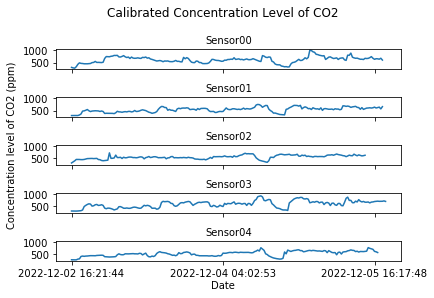

In [899]:
with np.load('LP8_Supervised_HMM_Sensors_1215.npz', allow_pickle=True) as file:
    print(type(file['pre']), file['pre'].shape, type(file['pre'][0]), file['pre'][0].shape)
    pre_CO2_list = file['pre']
    ref_CO2_list = file['ref']
    data_date_list = file['date']
    n_list = file['n']
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, sharey=True)
ax1.plot(np.arange(n_list[0]), pre_CO2_list[0], label='Sensor00')
ax1.set_title('Sensor00', fontdict={'size': 10})
#ax1.legend()
ax2.plot(np.arange(n_list[1]), pre_CO2_list[1], label='Sensor01')
ax2.set_title('Sensor01', fontdict={'size': 10})
#ax2.legend()
ax3.plot(np.arange(n_list[2]), pre_CO2_list[2], label='Sensor02')
ax3.set_title('Sensor02', fontdict={'size': 10})
#ax3.legend()
ax4.plot(np.arange(n_list[3]), pre_CO2_list[3], label='Sensor03')
ax4.set_title('Sensor03', fontdict={'size': 10})
#ax4.legend()
ax5.plot(np.arange(n_list[4]), pre_CO2_list[4], label='Sensor04')
ax5.set_title('Sensor04', fontdict={'size': 10})
#ax4.legend()
plt.xticks(np.arange(0, n_list[4], step=int(n_list[4] / 2 - 1)), data_date_list[4][:: int(n_list[4] / 2 - 1)])
plt.suptitle('Calibrated Concentration Level of CO2')
#f.text(0.5, 1, 'Concentration Level of CO2', ha='center')
f.text(0, 0.5, 'Concentration level of CO2 (ppm)', va='center', rotation='vertical')
f.text(0.5, 0, 'Date', ha='center')
plt.tight_layout()
plt.savefig('Sensors.png')
plt.show()

In [296]:
name_saved = './1207_5_days_diff/1205_LP8_Supervised_HMM_Sensor_' + label + '.npz'
np.savez(name_saved, pi=pi, A=A, B=B, pre_zeros=pre_zeros[stop: end], pre_CO2=pre_CO2[stop: end], param=param, bins_z = bins,  bins_co2=bins_CO2)

## Real prediction

In [ ]:
def detect_outliers(x):

    m = np.mean(x)
    std = np.std(x)
    outlier_idx = np.where((m - 3 * std > x) | (m + 3 * std < x))[0]

    return outlier_idx

data_path = './4 days with sensors in different rooms of apartment'
label = '00'
start = 0
length = 10000
step = 8

tr_start = 0
tr_end = 332

te_start = 333
te_end = 1000
path = data_path

# Obtain sensor parameters
info = pd.read_csv('SensorsParams.csv', delimiter=';', index_col=0)   # LP8 sensors
param = info.loc['S' + label, :]
# Preprocess data

# Format 2
data = pd.read_csv(path + '/kth_logger_' + label + '.csv', header=None)
print('raw data collected: ', len(data))
data = data.loc[:, [0, 4, 5, 7, 9]]
data = data.dropna()
data = data.drop(data.index[detect_outliers(data[4])])
data = data.drop(data.index[detect_outliers(data[5])])
data = data.drop(data.index[detect_outliers(data[7])])
data = data.drop(data.index[detect_outliers(data[9])])
print('rational data collected: ', len(data))

data['create_time'] = pd.date_range('01/01/2022 00:00:00', periods=len(data), freq='1T')
data.loc[:, 'create_time'] = pd.to_datetime(data.loc[:, 'create_time'])
data = data.set_index('create_time')
data_date = data[0].resample('16T').min()
data_ref = data[4].resample('16T').mean()
data_temp = data[5].resample('16T').mean()
data_mea = data[7].resample('16T').mean()
data_ir = data[9].resample('16T').mean()

data_date = np.array(data_date)
data_temp = np.array(data_temp)
data_ir = np.array(data_ir) / 256
data_CO2 = np.array(data_mea)
ref_CO2 = np.array(data_ref)
'''
# Format 1
data = pd.read_csv(path + '/kth_logger_' + label + '.csv', header=None, delimiter=';')
data = data.loc[:, [0, 1, 5, 6, 8, 10]]
data = data.dropna()
data = data.drop(data.index[detect_outliers(data[5])])
data = data.drop(data.index[detect_outliers(data[6])])
data = data.drop(data.index[detect_outliers(data[8])])
data = data.drop(data.index[detect_outliers(data[10])])
print('data collected: ', len(data))
data = data[start: start + step * length: step]
data_date = np.array(data[0] + ' ' + data[1])
data_temp = np.array(data[6])
data_ir = np.array(data[10]) / 256
data_CO2 = np.array(data[8])
ref_CO2 = np.array(data[5])
'''

# Calculate zero coefficients by interpolation with mapping table
zeros = zero_cal(cc_mea=ref_CO2, ir=data_ir, temp=data_temp, param=param)
mea_zeros = zero_cal(cc_mea=data_CO2, ir=data_ir, temp=data_temp, param=param)
'''
# Remove data corresponding to irrational zero coefficients
m = detect_outliers(zeros)
zeros = np.delete(zeros, m)
mea_zeros = np.delete(mea_zeros, m)
data_date = np.delete(data_date, m)
data_temp = np.delete(data_temp, m)
data_ir = np.delete(data_ir, m)
data_CO2 = np.delete(data_CO2, m)
ref_CO2 = np.delete(ref_CO2, m)

m = detect_outliers(zeros)
zeros = np.delete(zeros, m)
mea_zeros = np.delete(mea_zeros, m)
data_date = np.delete(data_date, m)
data_temp = np.delete(data_temp, m)
data_ir = np.delete(data_ir, m)
data_CO2 = np.delete(data_CO2, m)
ref_CO2 = np.delete(ref_CO2, m)
'''
m = detect_outliers(zeros)
zeros = np.delete(zeros, m)
mea_zeros = np.delete(mea_zeros, m)
data_date = np.delete(data_date, m)
data_temp = np.delete(data_temp, m)
data_ir = np.delete(data_ir, m)
data_CO2 = np.delete(data_CO2, m)
ref_CO2 = np.delete(ref_CO2, m)

N = len(zeros)
print('N: ', N)

print('min zero: {}, max zero: {}, mean zero: {:.1f}'.format(round(np.min(zeros)), round(np.max(zeros)), np.mean(zeros)))
print('min CO2: {}, max CO2: {}, mean CO2: {:.1f}'.format(round(np.min(data_CO2)), round(np.max(data_CO2)), np.mean(data_CO2)))
# plot_figs(y=[zeros], xticks=data_date, fig='zeros')
#plot_figs(y=[ref_CO2], xticks=data_date, fig='CO2_mea')
plot_figs(y=[data_CO2], xticks=data_date, fig='CO2_mea')
#plot_figs(y=[ref_CO2[tr_start: tr_end]], xticks=data_date[tr_start: tr_end], fig='CO2_mea')
#plot_figs(y=[ref_CO2[te_start: te_end]], xticks=data_date[te_start: te_end], fig='CO2_mea')
plot_figs(y=[data_CO2[tr_start: tr_end]], xticks=data_date[tr_start: tr_end], fig='CO2_mea')
plot_figs(y=[data_CO2[te_start: te_end]], xticks=data_date[te_start: te_end], fig='CO2_mea')

plot_figs(y=[zeros[tr_start: tr_end]], xticks=data_date[tr_start: tr_end], fig='zeros')
plot_figs(y=[zeros[te_start: te_end]], xticks=data_date[te_start: te_end], fig='zeros')

N = len(zeros[tr_start: tr_end])
print('training length N: ', N)
print('testing length N: ', len(zeros[te_start: te_end]))

print('min zero: {}, max zero: {}, mean zero: {:.1f}'.format(round(np.min(zeros[tr_start: tr_end])), round(np.max(zeros[tr_start: tr_end])), np.mean(zeros[tr_start: tr_end])))
print('min CO2: {}, max CO2: {}, mean CO2: {:.1f}'.format(round(np.min(data_CO2[tr_start: tr_end])), round(np.max(data_CO2[tr_start: tr_end])), np.mean(data_CO2[tr_start: tr_end])))
# Devise quantization scheme
bins = np.arange(13360, 13460, step=15)
zeros_q = np.digitize(zeros[tr_start: tr_end], bins, right=False)
itvl = bins[-1] - bins[-2]      # interval
nos = len(np.unique(zeros_q))   # number of states

bins_CO2 = np.arange(1000, 1800, step=30)
data_CO2_q = np.digitize(data_CO2[tr_start: tr_end], bins_CO2, right=False)
itvl_CO2 = bins_CO2[-1] - bins_CO2[-2]      # interval
noo = len(np.unique(data_CO2_q))            # number of observations

print('zero coefficients:\n\tbins: {} \n\tbincount: {} \n\tnumber of states: {} \n\tinterval: {} \n'.format(bins, np.bincount(zeros_q), nos, itvl))
print('CO2 levels:\n\tbins: {} \n\tbincount: {} \n\tnumber of CO2 levels: {}'.format(bins_CO2, np.bincount(data_CO2_q), noo))

In [864]:
### Learn model parameters
# Calculate initial state probability distribution pi
pi = np.zeros(nos)
for i in range(N):
    m = zeros_q[i]
    pi[m] += 1
pi /= np.sum(pi)

# Calculate transition probability matrix A
A = np.zeros((nos, nos))
for i in range(N - 1):
    m = zeros_q[i]
    n = zeros_q[i + 1]
    A[m][n] += 1
for i in range(nos):
    A[i] /= np.sum(A[i])

# Calculate observation probability matrix B
B = np.zeros((nos, noo))
for i in range(N - 1):
    j = zeros_q[i]
    m = data_CO2_q[i]
    B[j][m] += 1
for i in range(nos):
    B[i] /= np.sum(B[i])

In [ ]:
### Test with collected concentration levels of CO2
# Predict hidden states given observations
zeros_q = np.digitize(zeros[te_start: te_end], bins, right=False)
print('zeros bincount', np.bincount(zeros_q))
data_CO2_q = np.digitize(data_CO2[te_start: te_end], bins_CO2, right=False)
print('CO2 bincount: ', np.bincount(data_CO2_q))

pre_states = viterbi_log(data_CO2_q, pi, A, B)
plot_figs(y=[zeros_q, pre_states], xticks=data_date[te_start: te_end], fig='states')
# Map state index to its true value
pre_zeros = mapping(pre_states, bins)
# Introduce baseline of zero coefficients
N = len(zeros[te_start: te_end])
base_zeros = np.full(N, np.mean(zeros[te_start: te_end]))
# plot_figs(y=[zeros, pre_zeros, mea_zeros, base_zeros], xticks=data_date, fig='zeros')
# plot_figs(y=[zeros[stop: end], pre_zeros, mea_zeros[stop: end], base_zeros], xticks=data_date[stop: end], fig='zeros')
plot_figs(y=[zeros[te_start: te_end], pre_zeros, base_zeros], xticks=data_date[te_start: te_end], fig='zeros')

# Predict concentration levels of CO2 with predicted zero coefficients
pre_trans = table_entry(zero=pre_zeros, ir=data_ir[te_start: te_end], temp=data_temp[te_start: te_end], param=param)
base_trans = table_entry(zero=base_zeros, ir=data_ir[te_start: te_end], temp=data_temp[te_start: te_end], param=param)
# Interpolation
pre_CO2 = np.interp(pre_trans, te, cc)
base_CO2 = np.interp(base_trans, te, cc)
plot_figs(y=[ref_CO2[te_start: te_end], pre_CO2, data_CO2[te_start: te_end]], xticks=data_date[te_start: te_end], fig='CO2')
# plot_figs(y=[ref_CO2[stop: end], pre_CO2, data_CO2[stop: end], base_CO2], xticks=data_date[stop: end], fig='CO2')
#plot_figs(y=[ref_CO2, pre_CO2, data_CO2, base_CO2], xticks=data_date, fig='CO2')
# Evaluation
print('MSE(ref_zeros, mea_zeros): {:.3f} \nMSE(ref_zeros, pre_zeros): {:.3f} \nMSE(ref_zeros, base_zeros): {:.3f}\n'.format(np.sqrt(np.linalg.norm(zeros[te_start: te_end] - mea_zeros[te_start: te_end]) ** 2 / N), np.sqrt(np.linalg.norm(zeros[te_start: te_end] - pre_zeros) ** 2 / N), np.sqrt(np.linalg.norm(zeros[te_start: te_end] - base_zeros) ** 2 / N)))
print('MSE(ref_CO2, mea_CO2): {:.3f} \nMSE(ref_CO2, pre_CO2): {:.3f} \nMSE(ref_CO2, base_CO2): {:.3f}\n'.format(np.sqrt(np.linalg.norm(ref_CO2[te_start: te_end] - data_CO2[te_start: te_end]) ** 2 / N), np.sqrt(np.linalg.norm(ref_CO2[te_start: te_end] - pre_CO2) ** 2 / N), np.sqrt(np.linalg.norm(ref_CO2[te_start: te_end] - base_CO2) ** 2 / N)))

In [ ]:
plot_figs(y=[ref_CO2[te_start: te_end], pre_CO2], xticks=data_date[te_start: te_end], fig='CO2')

In [ ]:
plot_figs(y=[ref_CO2[te_start: te_end], pre_CO2, data_CO2[te_start: te_end], base_CO2], xticks=data_date[te_start: te_end], fig='CO2')

In [ ]:
plot_figs(y=[ref_CO2[te_start: te_end], pre_CO2], xticks=data_date[te_start: te_end], fig='CO2')